***REFERENCES***

https://machinelearningmastery.com/stateful-stateless-lstm-time-series-forecasting-python/?ref=hackernoon.com

https://machinelearningmastery.com/time-series-forecasting-long-short-term-memory-network-python/

Dynamic Forecasting

In [1]:
# import required libraries
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import tensorflow as ts
from math import gcd
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from tensorflow.keras.optimizers import Adam

In [2]:
def parser(x):
    return pd.datetime.strptime('190'+x, '%Y-%m')

In [3]:
dataset=pd.read_csv("Shampoo.csv", date_parser=parser,parse_dates=[0])
display(dataset.head(10))

C:\Users\dogan\AppData\Local\Temp\ipykernel_17912\4175343489.py:2: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  return pd.datetime.strptime('190'+x, '%Y-%m')


,Month,Sales
0,1901-01-01,266.0
1,1901-02-01,145.9
2,1901-03-01,183.1
3,1901-04-01,119.3
4,1901-05-01,180.3
5,1901-06-01,168.5
6,1901-07-01,231.8
7,1901-08-01,224.5
8,1901-09-01,192.8
9,1901-10-01,122.9


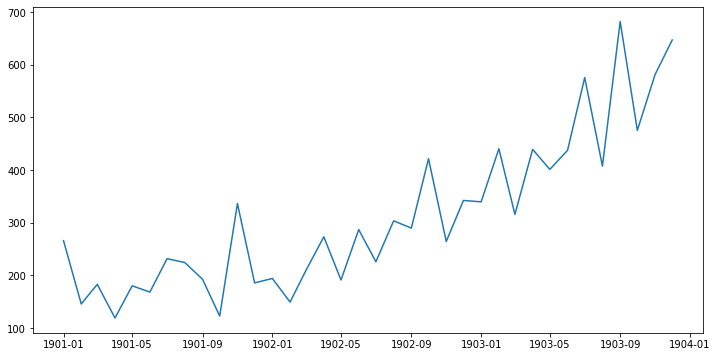

In [4]:
plt.figure(figsize=(12,6))
plt.plot(dataset["Month"].values, dataset["Sales"].values)

In [5]:
def timeseries_to_supervised(df,n_in, n_out):
    cols = list()
    names = list()
    for i in range(n_in,0,-1):
        cols.append(df["Sales"].shift(i))
        names += [("Sales(t-%d)"%(i))]
    for i in range(n_out):
        cols.append(df["Sales"].shift(-i))
        if i == 0:
            names += [("Sales(t)")]
        else:
            names += [("Sales(t+%d)"%(i))]
#     print(cols)
#     print(names)
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    agg["Month"] = df["Month"]
    agg.dropna(inplace=True)
    return agg
    

In [6]:
window = 10
n_months = 2
n_features = 1
df = timeseries_to_supervised(dataset, window, n_months)
display(df.head(10))

,Sales(t-10),Sales(t-9),Sales(t-8),Sales(t-7),Sales(t-6),Sales(t-5),Sales(t-4),Sales(t-3),Sales(t-2),Sales(t-1),Sales(t),Sales(t+1),Month
10,266.0,145.9,183.1,119.3,180.3,168.5,231.8,224.5,192.8,122.9,336.5,185.9,1901-11-01
11,145.9,183.1,119.3,180.3,168.5,231.8,224.5,192.8,122.9,336.5,185.9,194.3,1901-12-01
12,183.1,119.3,180.3,168.5,231.8,224.5,192.8,122.9,336.5,185.9,194.3,149.5,1902-01-01
13,119.3,180.3,168.5,231.8,224.5,192.8,122.9,336.5,185.9,194.3,149.5,210.1,1902-02-01
14,180.3,168.5,231.8,224.5,192.8,122.9,336.5,185.9,194.3,149.5,210.1,273.3,1902-03-01
15,168.5,231.8,224.5,192.8,122.9,336.5,185.9,194.3,149.5,210.1,273.3,191.4,1902-04-01
16,231.8,224.5,192.8,122.9,336.5,185.9,194.3,149.5,210.1,273.3,191.4,287.0,1902-05-01
17,224.5,192.8,122.9,336.5,185.9,194.3,149.5,210.1,273.3,191.4,287.0,226.0,1902-06-01
18,192.8,122.9,336.5,185.9,194.3,149.5,210.1,273.3,191.4,287.0,226.0,303.6,1902-07-01
19,122.9,336.5,185.9,194.3,149.5,210.1,273.3,191.4,287.0,226.0,303.6,289.9,1902-08-01


In [7]:
df.set_index("Month",inplace=True)

The trend can be removed from the observations, then added back to forecasts later to return the prediction to the original scale and calculate a comparable error score.

In [8]:
def scaled_transform(X,min_data, max_data, min_range=-1, max_range=1):
    X_std = (X-min_data)/(max_data-min_data)
    X_sc = X_std * (max_range - min_range) + (min_range)
    return np.array(X_sc)

In [9]:
# apply MinMaxScaler with feature range(-1,1)

min_data = df.values.min()
max_data = df.values.max()
print(min_data,max_data)
data_sc = scaled_transform(df,min_data, max_data)

119.3 682.0


In [10]:
train, test = data_sc[:-12,:], data_sc[-12:,:]
X_train, y_train = train[:,:-n_months], train[:,-n_months:]
X_test, y_test = test[:,:-n_months], test[:,-n_months:]

# reshape for LSTM
X_train = X_train.reshape(X_train.shape[0],window,n_features)
X_test = X_test.reshape(X_test.shape[0],window,n_features)
print(X_train.shape, X_test.shape)
print(y_train.shape, y_test.shape)

(13, 10, 1) (12, 10, 1)
(13, 2) (12, 2)


In [11]:
print("X train")
print(X_train[0])
print("y train")
print(y_train[0])
print("X test")
print(X_test[0])
print("y test")
print(y_test[0])

X train
[[-0.47858539]
 [-0.90545584]
 [-0.77323618]
 [-1.        ]
 [-0.7831882 ]
 [-0.82512884]
 [-0.60014217]
 [-0.6260885 ]
 [-0.73875955]
 [-0.98720455]]
y train
[-0.22800782 -0.76328417]
X test
[[-0.89266039]
 [-0.6772703 ]
 [-0.45263906]
 [-0.74373556]
 [-0.40394526]
 [-0.62075706]
 [-0.34494402]
 [-0.39363782]
 [ 0.07446241]
 [-0.48391683]]
y test
[-0.20739293 -0.21663409]


In [12]:
# create LSTM model
batch_size = 1
epochs = 2500

model = Sequential()
model.add(LSTM(16,batch_size=(batch_size,window,n_features),stateful=True, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(10,return_sequences=False))
model.add(Dense(n_months))
model.compile(optimizer=Adam(learning_rate=0.00001),loss="mean_squared_error")

In [13]:
# train the stateful LSTM model
train_loss = []
val_loss = []
for epoch in range(epochs): 
    history = model.fit(X_train,y_train,epochs=1, batch_size=batch_size,verbose=2,shuffle=False, validation_split=0.3)
    train_loss.append(history.history["loss"])
    val_loss.append(history.history["val_loss"])
    model.reset_states()


9/9 - 11s - loss: 0.5586 - val_loss: 0.1793 - 11s/epoch - 1s/step
9/9 - 0s - loss: 0.5614 - val_loss: 0.1780 - 234ms/epoch - 26ms/step
9/9 - 0s - loss: 0.5614 - val_loss: 0.1766 - 235ms/epoch - 26ms/step
9/9 - 0s - loss: 0.5532 - val_loss: 0.1752 - 239ms/epoch - 27ms/step
9/9 - 0s - loss: 0.5508 - val_loss: 0.1739 - 232ms/epoch - 26ms/step
9/9 - 0s - loss: 0.5477 - val_loss: 0.1726 - 229ms/epoch - 25ms/step
9/9 - 0s - loss: 0.5428 - val_loss: 0.1713 - 232ms/epoch - 26ms/step
9/9 - 0s - loss: 0.5358 - val_loss: 0.1699 - 227ms/epoch - 25ms/step
9/9 - 0s - loss: 0.5412 - val_loss: 0.1687 - 230ms/epoch - 26ms/step
9/9 - 0s - loss: 0.5191 - val_loss: 0.1674 - 223ms/epoch - 25ms/step
9/9 - 0s - loss: 0.5315 - val_loss: 0.1661 - 235ms/epoch - 26ms/step
9/9 - 0s - loss: 0.5355 - val_loss: 0.1649 - 249ms/epoch - 28ms/step
9/9 - 0s - loss: 0.5243 - val_loss: 0.1636 - 238ms/epoch - 26ms/step
9/9 - 0s - loss: 0.5166 - val_loss: 0.1623 - 229ms/epoch - 25ms/step
9/9 - 0s - loss: 0.5147 - val_loss: 0

9/9 - 0s - loss: 0.2896 - val_loss: 0.0725 - 238ms/epoch - 26ms/step
9/9 - 0s - loss: 0.2692 - val_loss: 0.0720 - 220ms/epoch - 24ms/step
9/9 - 0s - loss: 0.2704 - val_loss: 0.0714 - 236ms/epoch - 26ms/step
9/9 - 0s - loss: 0.2757 - val_loss: 0.0709 - 227ms/epoch - 25ms/step
9/9 - 0s - loss: 0.2686 - val_loss: 0.0704 - 214ms/epoch - 24ms/step
9/9 - 0s - loss: 0.2780 - val_loss: 0.0699 - 213ms/epoch - 24ms/step
9/9 - 0s - loss: 0.2737 - val_loss: 0.0694 - 200ms/epoch - 22ms/step
9/9 - 0s - loss: 0.2677 - val_loss: 0.0689 - 218ms/epoch - 24ms/step
9/9 - 0s - loss: 0.2624 - val_loss: 0.0684 - 207ms/epoch - 23ms/step
9/9 - 0s - loss: 0.2595 - val_loss: 0.0680 - 212ms/epoch - 24ms/step
9/9 - 0s - loss: 0.2573 - val_loss: 0.0675 - 264ms/epoch - 29ms/step
9/9 - 0s - loss: 0.2553 - val_loss: 0.0670 - 249ms/epoch - 28ms/step
9/9 - 0s - loss: 0.2630 - val_loss: 0.0666 - 232ms/epoch - 26ms/step
9/9 - 0s - loss: 0.2526 - val_loss: 0.0661 - 232ms/epoch - 26ms/step
9/9 - 0s - loss: 0.2556 - val_loss

9/9 - 0s - loss: 0.1136 - val_loss: 0.0496 - 231ms/epoch - 26ms/step
9/9 - 0s - loss: 0.1070 - val_loss: 0.0497 - 229ms/epoch - 25ms/step
9/9 - 0s - loss: 0.1127 - val_loss: 0.0499 - 230ms/epoch - 26ms/step
9/9 - 0s - loss: 0.1207 - val_loss: 0.0500 - 233ms/epoch - 26ms/step
9/9 - 0s - loss: 0.1057 - val_loss: 0.0502 - 229ms/epoch - 25ms/step
9/9 - 0s - loss: 0.1108 - val_loss: 0.0503 - 231ms/epoch - 26ms/step
9/9 - 0s - loss: 0.1090 - val_loss: 0.0505 - 235ms/epoch - 26ms/step
9/9 - 0s - loss: 0.1121 - val_loss: 0.0507 - 232ms/epoch - 26ms/step
9/9 - 0s - loss: 0.1051 - val_loss: 0.0508 - 254ms/epoch - 28ms/step
9/9 - 0s - loss: 0.1105 - val_loss: 0.0510 - 249ms/epoch - 28ms/step
9/9 - 0s - loss: 0.1030 - val_loss: 0.0512 - 237ms/epoch - 26ms/step
9/9 - 0s - loss: 0.1103 - val_loss: 0.0514 - 238ms/epoch - 26ms/step
9/9 - 0s - loss: 0.0968 - val_loss: 0.0516 - 234ms/epoch - 26ms/step
9/9 - 0s - loss: 0.0993 - val_loss: 0.0518 - 235ms/epoch - 26ms/step
9/9 - 0s - loss: 0.0917 - val_loss

9/9 - 0s - loss: 0.0455 - val_loss: 0.0932 - 239ms/epoch - 27ms/step
9/9 - 0s - loss: 0.0443 - val_loss: 0.0937 - 238ms/epoch - 26ms/step
9/9 - 0s - loss: 0.0467 - val_loss: 0.0942 - 228ms/epoch - 25ms/step
9/9 - 0s - loss: 0.0419 - val_loss: 0.0947 - 234ms/epoch - 26ms/step
9/9 - 0s - loss: 0.0438 - val_loss: 0.0951 - 238ms/epoch - 26ms/step
9/9 - 0s - loss: 0.0450 - val_loss: 0.0956 - 236ms/epoch - 26ms/step
9/9 - 0s - loss: 0.0422 - val_loss: 0.0961 - 242ms/epoch - 27ms/step
9/9 - 0s - loss: 0.0424 - val_loss: 0.0965 - 243ms/epoch - 27ms/step
9/9 - 0s - loss: 0.0401 - val_loss: 0.0970 - 249ms/epoch - 28ms/step
9/9 - 0s - loss: 0.0390 - val_loss: 0.0974 - 242ms/epoch - 27ms/step
9/9 - 0s - loss: 0.0418 - val_loss: 0.0978 - 240ms/epoch - 27ms/step
9/9 - 0s - loss: 0.0465 - val_loss: 0.0983 - 223ms/epoch - 25ms/step
9/9 - 0s - loss: 0.0336 - val_loss: 0.0987 - 212ms/epoch - 24ms/step
9/9 - 0s - loss: 0.0347 - val_loss: 0.0991 - 207ms/epoch - 23ms/step
9/9 - 0s - loss: 0.0438 - val_loss

9/9 - 0s - loss: 0.0396 - val_loss: 0.1323 - 228ms/epoch - 25ms/step
9/9 - 0s - loss: 0.0339 - val_loss: 0.1324 - 213ms/epoch - 24ms/step
9/9 - 0s - loss: 0.0399 - val_loss: 0.1327 - 203ms/epoch - 23ms/step
9/9 - 0s - loss: 0.0329 - val_loss: 0.1329 - 214ms/epoch - 24ms/step
9/9 - 0s - loss: 0.0316 - val_loss: 0.1330 - 208ms/epoch - 23ms/step
9/9 - 0s - loss: 0.0351 - val_loss: 0.1333 - 223ms/epoch - 25ms/step
9/9 - 0s - loss: 0.0328 - val_loss: 0.1335 - 211ms/epoch - 23ms/step
9/9 - 0s - loss: 0.0362 - val_loss: 0.1337 - 236ms/epoch - 26ms/step
9/9 - 0s - loss: 0.0332 - val_loss: 0.1339 - 235ms/epoch - 26ms/step
9/9 - 0s - loss: 0.0335 - val_loss: 0.1340 - 221ms/epoch - 25ms/step
9/9 - 0s - loss: 0.0335 - val_loss: 0.1342 - 235ms/epoch - 26ms/step
9/9 - 0s - loss: 0.0389 - val_loss: 0.1344 - 227ms/epoch - 25ms/step
9/9 - 0s - loss: 0.0333 - val_loss: 0.1346 - 230ms/epoch - 26ms/step
9/9 - 0s - loss: 0.0330 - val_loss: 0.1348 - 226ms/epoch - 25ms/step
9/9 - 0s - loss: 0.0346 - val_loss

9/9 - 0s - loss: 0.0384 - val_loss: 0.1435 - 229ms/epoch - 25ms/step
9/9 - 0s - loss: 0.0377 - val_loss: 0.1436 - 189ms/epoch - 21ms/step
9/9 - 0s - loss: 0.0333 - val_loss: 0.1437 - 230ms/epoch - 26ms/step
9/9 - 0s - loss: 0.0319 - val_loss: 0.1437 - 218ms/epoch - 24ms/step
9/9 - 0s - loss: 0.0400 - val_loss: 0.1438 - 239ms/epoch - 27ms/step
9/9 - 0s - loss: 0.0340 - val_loss: 0.1439 - 229ms/epoch - 25ms/step
9/9 - 0s - loss: 0.0335 - val_loss: 0.1438 - 232ms/epoch - 26ms/step
9/9 - 0s - loss: 0.0355 - val_loss: 0.1438 - 235ms/epoch - 26ms/step
9/9 - 0s - loss: 0.0315 - val_loss: 0.1438 - 229ms/epoch - 25ms/step
9/9 - 0s - loss: 0.0377 - val_loss: 0.1439 - 231ms/epoch - 26ms/step
9/9 - 0s - loss: 0.0301 - val_loss: 0.1440 - 219ms/epoch - 24ms/step
9/9 - 0s - loss: 0.0356 - val_loss: 0.1440 - 238ms/epoch - 26ms/step
9/9 - 0s - loss: 0.0351 - val_loss: 0.1440 - 224ms/epoch - 25ms/step
9/9 - 0s - loss: 0.0387 - val_loss: 0.1439 - 232ms/epoch - 26ms/step
9/9 - 0s - loss: 0.0351 - val_loss

9/9 - 0s - loss: 0.0369 - val_loss: 0.1417 - 227ms/epoch - 25ms/step
9/9 - 0s - loss: 0.0376 - val_loss: 0.1418 - 221ms/epoch - 25ms/step
9/9 - 0s - loss: 0.0345 - val_loss: 0.1418 - 237ms/epoch - 26ms/step
9/9 - 0s - loss: 0.0301 - val_loss: 0.1417 - 217ms/epoch - 24ms/step
9/9 - 0s - loss: 0.0342 - val_loss: 0.1417 - 234ms/epoch - 26ms/step
9/9 - 0s - loss: 0.0331 - val_loss: 0.1416 - 233ms/epoch - 26ms/step
9/9 - 0s - loss: 0.0350 - val_loss: 0.1414 - 242ms/epoch - 27ms/step
9/9 - 0s - loss: 0.0377 - val_loss: 0.1413 - 230ms/epoch - 26ms/step
9/9 - 0s - loss: 0.0325 - val_loss: 0.1413 - 225ms/epoch - 25ms/step
9/9 - 0s - loss: 0.0362 - val_loss: 0.1414 - 227ms/epoch - 25ms/step
9/9 - 0s - loss: 0.0343 - val_loss: 0.1416 - 221ms/epoch - 25ms/step
9/9 - 0s - loss: 0.0346 - val_loss: 0.1416 - 230ms/epoch - 26ms/step
9/9 - 0s - loss: 0.0383 - val_loss: 0.1417 - 214ms/epoch - 24ms/step
9/9 - 0s - loss: 0.0315 - val_loss: 0.1417 - 215ms/epoch - 24ms/step
9/9 - 0s - loss: 0.0395 - val_loss

9/9 - 0s - loss: 0.0328 - val_loss: 0.1430 - 213ms/epoch - 24ms/step
9/9 - 0s - loss: 0.0383 - val_loss: 0.1429 - 211ms/epoch - 23ms/step
9/9 - 0s - loss: 0.0319 - val_loss: 0.1428 - 212ms/epoch - 24ms/step
9/9 - 0s - loss: 0.0349 - val_loss: 0.1429 - 198ms/epoch - 22ms/step
9/9 - 0s - loss: 0.0399 - val_loss: 0.1431 - 210ms/epoch - 23ms/step
9/9 - 0s - loss: 0.0330 - val_loss: 0.1431 - 212ms/epoch - 24ms/step
9/9 - 0s - loss: 0.0357 - val_loss: 0.1430 - 230ms/epoch - 26ms/step
9/9 - 0s - loss: 0.0341 - val_loss: 0.1431 - 237ms/epoch - 26ms/step
9/9 - 0s - loss: 0.0333 - val_loss: 0.1430 - 229ms/epoch - 25ms/step
9/9 - 0s - loss: 0.0326 - val_loss: 0.1429 - 235ms/epoch - 26ms/step
9/9 - 0s - loss: 0.0300 - val_loss: 0.1430 - 223ms/epoch - 25ms/step
9/9 - 0s - loss: 0.0319 - val_loss: 0.1431 - 232ms/epoch - 26ms/step
9/9 - 0s - loss: 0.0334 - val_loss: 0.1431 - 226ms/epoch - 25ms/step
9/9 - 0s - loss: 0.0325 - val_loss: 0.1430 - 237ms/epoch - 26ms/step
9/9 - 0s - loss: 0.0348 - val_loss

9/9 - 0s - loss: 0.0326 - val_loss: 0.1421 - 241ms/epoch - 27ms/step
9/9 - 0s - loss: 0.0311 - val_loss: 0.1421 - 222ms/epoch - 25ms/step
9/9 - 0s - loss: 0.0322 - val_loss: 0.1422 - 228ms/epoch - 25ms/step
9/9 - 0s - loss: 0.0321 - val_loss: 0.1423 - 220ms/epoch - 24ms/step
9/9 - 0s - loss: 0.0315 - val_loss: 0.1424 - 245ms/epoch - 27ms/step
9/9 - 0s - loss: 0.0313 - val_loss: 0.1425 - 232ms/epoch - 26ms/step
9/9 - 0s - loss: 0.0342 - val_loss: 0.1426 - 232ms/epoch - 26ms/step
9/9 - 0s - loss: 0.0333 - val_loss: 0.1426 - 231ms/epoch - 26ms/step
9/9 - 0s - loss: 0.0350 - val_loss: 0.1425 - 224ms/epoch - 25ms/step
9/9 - 0s - loss: 0.0367 - val_loss: 0.1425 - 229ms/epoch - 25ms/step
9/9 - 0s - loss: 0.0351 - val_loss: 0.1424 - 218ms/epoch - 24ms/step
9/9 - 0s - loss: 0.0341 - val_loss: 0.1423 - 229ms/epoch - 25ms/step
9/9 - 0s - loss: 0.0391 - val_loss: 0.1423 - 228ms/epoch - 25ms/step
9/9 - 0s - loss: 0.0348 - val_loss: 0.1423 - 238ms/epoch - 26ms/step
9/9 - 0s - loss: 0.0332 - val_loss

9/9 - 0s - loss: 0.0312 - val_loss: 0.1432 - 251ms/epoch - 28ms/step
9/9 - 0s - loss: 0.0368 - val_loss: 0.1431 - 251ms/epoch - 28ms/step
9/9 - 0s - loss: 0.0324 - val_loss: 0.1430 - 251ms/epoch - 28ms/step
9/9 - 0s - loss: 0.0329 - val_loss: 0.1432 - 227ms/epoch - 25ms/step
9/9 - 0s - loss: 0.0328 - val_loss: 0.1433 - 252ms/epoch - 28ms/step
9/9 - 0s - loss: 0.0324 - val_loss: 0.1433 - 234ms/epoch - 26ms/step
9/9 - 0s - loss: 0.0342 - val_loss: 0.1434 - 249ms/epoch - 28ms/step
9/9 - 0s - loss: 0.0385 - val_loss: 0.1435 - 240ms/epoch - 27ms/step
9/9 - 0s - loss: 0.0354 - val_loss: 0.1435 - 239ms/epoch - 27ms/step
9/9 - 0s - loss: 0.0364 - val_loss: 0.1436 - 237ms/epoch - 26ms/step
9/9 - 0s - loss: 0.0346 - val_loss: 0.1438 - 230ms/epoch - 26ms/step
9/9 - 0s - loss: 0.0305 - val_loss: 0.1438 - 224ms/epoch - 25ms/step
9/9 - 0s - loss: 0.0325 - val_loss: 0.1438 - 222ms/epoch - 25ms/step
9/9 - 0s - loss: 0.0375 - val_loss: 0.1438 - 226ms/epoch - 25ms/step
9/9 - 0s - loss: 0.0334 - val_loss

9/9 - 0s - loss: 0.0325 - val_loss: 0.1431 - 212ms/epoch - 24ms/step
9/9 - 0s - loss: 0.0288 - val_loss: 0.1430 - 214ms/epoch - 24ms/step
9/9 - 0s - loss: 0.0326 - val_loss: 0.1429 - 206ms/epoch - 23ms/step
9/9 - 0s - loss: 0.0340 - val_loss: 0.1428 - 226ms/epoch - 25ms/step
9/9 - 0s - loss: 0.0304 - val_loss: 0.1428 - 215ms/epoch - 24ms/step
9/9 - 0s - loss: 0.0280 - val_loss: 0.1428 - 234ms/epoch - 26ms/step
9/9 - 0s - loss: 0.0321 - val_loss: 0.1429 - 223ms/epoch - 25ms/step
9/9 - 0s - loss: 0.0296 - val_loss: 0.1429 - 237ms/epoch - 26ms/step
9/9 - 0s - loss: 0.0379 - val_loss: 0.1429 - 228ms/epoch - 25ms/step
9/9 - 0s - loss: 0.0362 - val_loss: 0.1429 - 224ms/epoch - 25ms/step
9/9 - 0s - loss: 0.0309 - val_loss: 0.1430 - 229ms/epoch - 25ms/step
9/9 - 0s - loss: 0.0361 - val_loss: 0.1430 - 222ms/epoch - 25ms/step
9/9 - 0s - loss: 0.0350 - val_loss: 0.1428 - 229ms/epoch - 25ms/step
9/9 - 0s - loss: 0.0351 - val_loss: 0.1426 - 229ms/epoch - 25ms/step
9/9 - 0s - loss: 0.0318 - val_loss

9/9 - 0s - loss: 0.0337 - val_loss: 0.1431 - 222ms/epoch - 25ms/step
9/9 - 0s - loss: 0.0423 - val_loss: 0.1431 - 229ms/epoch - 25ms/step
9/9 - 0s - loss: 0.0331 - val_loss: 0.1430 - 225ms/epoch - 25ms/step
9/9 - 0s - loss: 0.0299 - val_loss: 0.1429 - 230ms/epoch - 26ms/step
9/9 - 0s - loss: 0.0320 - val_loss: 0.1428 - 229ms/epoch - 25ms/step
9/9 - 0s - loss: 0.0326 - val_loss: 0.1428 - 248ms/epoch - 28ms/step
9/9 - 0s - loss: 0.0315 - val_loss: 0.1428 - 228ms/epoch - 25ms/step
9/9 - 0s - loss: 0.0331 - val_loss: 0.1428 - 226ms/epoch - 25ms/step
9/9 - 0s - loss: 0.0333 - val_loss: 0.1428 - 246ms/epoch - 27ms/step
9/9 - 0s - loss: 0.0330 - val_loss: 0.1427 - 254ms/epoch - 28ms/step
9/9 - 0s - loss: 0.0386 - val_loss: 0.1426 - 233ms/epoch - 26ms/step
9/9 - 0s - loss: 0.0359 - val_loss: 0.1426 - 254ms/epoch - 28ms/step
9/9 - 0s - loss: 0.0343 - val_loss: 0.1426 - 232ms/epoch - 26ms/step
9/9 - 0s - loss: 0.0348 - val_loss: 0.1426 - 243ms/epoch - 27ms/step
9/9 - 0s - loss: 0.0309 - val_loss

9/9 - 0s - loss: 0.0254 - val_loss: 0.1414 - 231ms/epoch - 26ms/step
9/9 - 0s - loss: 0.0381 - val_loss: 0.1416 - 230ms/epoch - 26ms/step
9/9 - 0s - loss: 0.0309 - val_loss: 0.1417 - 230ms/epoch - 26ms/step
9/9 - 0s - loss: 0.0308 - val_loss: 0.1418 - 236ms/epoch - 26ms/step
9/9 - 0s - loss: 0.0334 - val_loss: 0.1418 - 222ms/epoch - 25ms/step
9/9 - 0s - loss: 0.0331 - val_loss: 0.1418 - 226ms/epoch - 25ms/step
9/9 - 0s - loss: 0.0293 - val_loss: 0.1417 - 235ms/epoch - 26ms/step
9/9 - 0s - loss: 0.0310 - val_loss: 0.1417 - 210ms/epoch - 23ms/step
9/9 - 0s - loss: 0.0280 - val_loss: 0.1418 - 214ms/epoch - 24ms/step
9/9 - 0s - loss: 0.0305 - val_loss: 0.1420 - 210ms/epoch - 23ms/step
9/9 - 0s - loss: 0.0322 - val_loss: 0.1421 - 228ms/epoch - 25ms/step
9/9 - 0s - loss: 0.0332 - val_loss: 0.1421 - 203ms/epoch - 23ms/step
9/9 - 0s - loss: 0.0316 - val_loss: 0.1421 - 217ms/epoch - 24ms/step
9/9 - 0s - loss: 0.0312 - val_loss: 0.1421 - 215ms/epoch - 24ms/step
9/9 - 0s - loss: 0.0311 - val_loss

9/9 - 0s - loss: 0.0340 - val_loss: 0.1419 - 205ms/epoch - 23ms/step
9/9 - 0s - loss: 0.0339 - val_loss: 0.1419 - 214ms/epoch - 24ms/step
9/9 - 0s - loss: 0.0346 - val_loss: 0.1419 - 218ms/epoch - 24ms/step
9/9 - 0s - loss: 0.0274 - val_loss: 0.1418 - 230ms/epoch - 26ms/step
9/9 - 0s - loss: 0.0357 - val_loss: 0.1418 - 236ms/epoch - 26ms/step
9/9 - 0s - loss: 0.0389 - val_loss: 0.1420 - 229ms/epoch - 25ms/step
9/9 - 0s - loss: 0.0300 - val_loss: 0.1420 - 229ms/epoch - 25ms/step
9/9 - 0s - loss: 0.0321 - val_loss: 0.1420 - 219ms/epoch - 24ms/step
9/9 - 0s - loss: 0.0285 - val_loss: 0.1421 - 228ms/epoch - 25ms/step
9/9 - 0s - loss: 0.0311 - val_loss: 0.1423 - 222ms/epoch - 25ms/step
9/9 - 0s - loss: 0.0321 - val_loss: 0.1424 - 228ms/epoch - 25ms/step
9/9 - 0s - loss: 0.0271 - val_loss: 0.1424 - 230ms/epoch - 26ms/step
9/9 - 0s - loss: 0.0305 - val_loss: 0.1424 - 229ms/epoch - 25ms/step
9/9 - 0s - loss: 0.0290 - val_loss: 0.1424 - 242ms/epoch - 27ms/step
9/9 - 0s - loss: 0.0339 - val_loss

9/9 - 0s - loss: 0.0336 - val_loss: 0.1412 - 273ms/epoch - 30ms/step
9/9 - 0s - loss: 0.0370 - val_loss: 0.1411 - 245ms/epoch - 27ms/step
9/9 - 0s - loss: 0.0344 - val_loss: 0.1410 - 249ms/epoch - 28ms/step
9/9 - 0s - loss: 0.0335 - val_loss: 0.1409 - 228ms/epoch - 25ms/step
9/9 - 0s - loss: 0.0344 - val_loss: 0.1408 - 241ms/epoch - 27ms/step
9/9 - 0s - loss: 0.0326 - val_loss: 0.1407 - 221ms/epoch - 25ms/step
9/9 - 0s - loss: 0.0326 - val_loss: 0.1406 - 230ms/epoch - 26ms/step
9/9 - 0s - loss: 0.0308 - val_loss: 0.1406 - 225ms/epoch - 25ms/step
9/9 - 0s - loss: 0.0299 - val_loss: 0.1406 - 229ms/epoch - 25ms/step
9/9 - 0s - loss: 0.0313 - val_loss: 0.1407 - 229ms/epoch - 25ms/step
9/9 - 0s - loss: 0.0320 - val_loss: 0.1409 - 232ms/epoch - 26ms/step
9/9 - 0s - loss: 0.0305 - val_loss: 0.1410 - 228ms/epoch - 25ms/step
9/9 - 0s - loss: 0.0322 - val_loss: 0.1412 - 219ms/epoch - 24ms/step
9/9 - 0s - loss: 0.0331 - val_loss: 0.1414 - 238ms/epoch - 26ms/step
9/9 - 0s - loss: 0.0319 - val_loss

9/9 - 0s - loss: 0.0320 - val_loss: 0.1405 - 220ms/epoch - 24ms/step
9/9 - 0s - loss: 0.0368 - val_loss: 0.1406 - 230ms/epoch - 26ms/step
9/9 - 0s - loss: 0.0316 - val_loss: 0.1407 - 227ms/epoch - 25ms/step
9/9 - 0s - loss: 0.0355 - val_loss: 0.1408 - 230ms/epoch - 26ms/step
9/9 - 0s - loss: 0.0317 - val_loss: 0.1408 - 233ms/epoch - 26ms/step
9/9 - 0s - loss: 0.0307 - val_loss: 0.1409 - 214ms/epoch - 24ms/step
9/9 - 0s - loss: 0.0314 - val_loss: 0.1408 - 213ms/epoch - 24ms/step
9/9 - 0s - loss: 0.0390 - val_loss: 0.1409 - 197ms/epoch - 22ms/step
9/9 - 0s - loss: 0.0316 - val_loss: 0.1409 - 216ms/epoch - 24ms/step
9/9 - 0s - loss: 0.0323 - val_loss: 0.1409 - 210ms/epoch - 23ms/step
9/9 - 0s - loss: 0.0297 - val_loss: 0.1409 - 215ms/epoch - 24ms/step
9/9 - 0s - loss: 0.0319 - val_loss: 0.1409 - 229ms/epoch - 25ms/step
9/9 - 0s - loss: 0.0310 - val_loss: 0.1409 - 229ms/epoch - 25ms/step
9/9 - 0s - loss: 0.0324 - val_loss: 0.1408 - 231ms/epoch - 26ms/step
9/9 - 0s - loss: 0.0304 - val_loss

9/9 - 0s - loss: 0.0307 - val_loss: 0.1407 - 217ms/epoch - 24ms/step
9/9 - 0s - loss: 0.0314 - val_loss: 0.1407 - 207ms/epoch - 23ms/step
9/9 - 0s - loss: 0.0303 - val_loss: 0.1408 - 218ms/epoch - 24ms/step
9/9 - 0s - loss: 0.0392 - val_loss: 0.1408 - 214ms/epoch - 24ms/step
9/9 - 0s - loss: 0.0329 - val_loss: 0.1409 - 212ms/epoch - 24ms/step
9/9 - 0s - loss: 0.0325 - val_loss: 0.1410 - 211ms/epoch - 23ms/step
9/9 - 0s - loss: 0.0278 - val_loss: 0.1411 - 218ms/epoch - 24ms/step
9/9 - 0s - loss: 0.0306 - val_loss: 0.1413 - 219ms/epoch - 24ms/step
9/9 - 0s - loss: 0.0320 - val_loss: 0.1415 - 214ms/epoch - 24ms/step
9/9 - 0s - loss: 0.0339 - val_loss: 0.1416 - 215ms/epoch - 24ms/step
9/9 - 0s - loss: 0.0333 - val_loss: 0.1416 - 217ms/epoch - 24ms/step
9/9 - 0s - loss: 0.0331 - val_loss: 0.1415 - 216ms/epoch - 24ms/step
9/9 - 0s - loss: 0.0342 - val_loss: 0.1414 - 218ms/epoch - 24ms/step
9/9 - 0s - loss: 0.0320 - val_loss: 0.1412 - 210ms/epoch - 23ms/step
9/9 - 0s - loss: 0.0332 - val_loss

9/9 - 0s - loss: 0.0316 - val_loss: 0.1402 - 199ms/epoch - 22ms/step
9/9 - 0s - loss: 0.0304 - val_loss: 0.1402 - 201ms/epoch - 22ms/step
9/9 - 0s - loss: 0.0342 - val_loss: 0.1402 - 213ms/epoch - 24ms/step
9/9 - 0s - loss: 0.0293 - val_loss: 0.1401 - 201ms/epoch - 22ms/step
9/9 - 0s - loss: 0.0321 - val_loss: 0.1400 - 201ms/epoch - 22ms/step
9/9 - 0s - loss: 0.0352 - val_loss: 0.1399 - 200ms/epoch - 22ms/step
9/9 - 0s - loss: 0.0314 - val_loss: 0.1399 - 212ms/epoch - 24ms/step
9/9 - 0s - loss: 0.0339 - val_loss: 0.1400 - 200ms/epoch - 22ms/step
9/9 - 0s - loss: 0.0341 - val_loss: 0.1403 - 202ms/epoch - 22ms/step
9/9 - 0s - loss: 0.0283 - val_loss: 0.1404 - 202ms/epoch - 22ms/step
9/9 - 0s - loss: 0.0314 - val_loss: 0.1404 - 201ms/epoch - 22ms/step
9/9 - 0s - loss: 0.0376 - val_loss: 0.1404 - 199ms/epoch - 22ms/step
9/9 - 0s - loss: 0.0313 - val_loss: 0.1404 - 202ms/epoch - 22ms/step
9/9 - 0s - loss: 0.0364 - val_loss: 0.1403 - 198ms/epoch - 22ms/step
9/9 - 0s - loss: 0.0329 - val_loss

9/9 - 0s - loss: 0.0307 - val_loss: 0.1404 - 213ms/epoch - 24ms/step
9/9 - 0s - loss: 0.0313 - val_loss: 0.1402 - 200ms/epoch - 22ms/step
9/9 - 0s - loss: 0.0371 - val_loss: 0.1400 - 199ms/epoch - 22ms/step
9/9 - 0s - loss: 0.0307 - val_loss: 0.1398 - 203ms/epoch - 23ms/step
9/9 - 0s - loss: 0.0310 - val_loss: 0.1397 - 201ms/epoch - 22ms/step
9/9 - 0s - loss: 0.0328 - val_loss: 0.1396 - 199ms/epoch - 22ms/step
9/9 - 0s - loss: 0.0348 - val_loss: 0.1395 - 200ms/epoch - 22ms/step
9/9 - 0s - loss: 0.0339 - val_loss: 0.1393 - 200ms/epoch - 22ms/step
9/9 - 0s - loss: 0.0336 - val_loss: 0.1391 - 198ms/epoch - 22ms/step
9/9 - 0s - loss: 0.0338 - val_loss: 0.1389 - 206ms/epoch - 23ms/step
9/9 - 0s - loss: 0.0341 - val_loss: 0.1388 - 202ms/epoch - 22ms/step
9/9 - 0s - loss: 0.0298 - val_loss: 0.1388 - 197ms/epoch - 22ms/step
9/9 - 0s - loss: 0.0360 - val_loss: 0.1390 - 203ms/epoch - 23ms/step
9/9 - 0s - loss: 0.0282 - val_loss: 0.1390 - 208ms/epoch - 23ms/step
9/9 - 0s - loss: 0.0325 - val_loss

9/9 - 0s - loss: 0.0321 - val_loss: 0.1405 - 205ms/epoch - 23ms/step
9/9 - 0s - loss: 0.0322 - val_loss: 0.1403 - 199ms/epoch - 22ms/step
9/9 - 0s - loss: 0.0345 - val_loss: 0.1403 - 198ms/epoch - 22ms/step
9/9 - 0s - loss: 0.0300 - val_loss: 0.1403 - 199ms/epoch - 22ms/step
9/9 - 0s - loss: 0.0314 - val_loss: 0.1403 - 208ms/epoch - 23ms/step
9/9 - 0s - loss: 0.0331 - val_loss: 0.1404 - 209ms/epoch - 23ms/step
9/9 - 0s - loss: 0.0272 - val_loss: 0.1402 - 200ms/epoch - 22ms/step
9/9 - 0s - loss: 0.0306 - val_loss: 0.1401 - 200ms/epoch - 22ms/step
9/9 - 0s - loss: 0.0258 - val_loss: 0.1400 - 201ms/epoch - 22ms/step
9/9 - 0s - loss: 0.0285 - val_loss: 0.1400 - 186ms/epoch - 21ms/step
9/9 - 0s - loss: 0.0349 - val_loss: 0.1402 - 186ms/epoch - 21ms/step
9/9 - 0s - loss: 0.0320 - val_loss: 0.1402 - 185ms/epoch - 21ms/step
9/9 - 0s - loss: 0.0330 - val_loss: 0.1402 - 186ms/epoch - 21ms/step
9/9 - 0s - loss: 0.0293 - val_loss: 0.1401 - 190ms/epoch - 21ms/step
9/9 - 0s - loss: 0.0326 - val_loss

9/9 - 0s - loss: 0.0315 - val_loss: 0.1406 - 203ms/epoch - 23ms/step
9/9 - 0s - loss: 0.0389 - val_loss: 0.1405 - 197ms/epoch - 22ms/step
9/9 - 0s - loss: 0.0340 - val_loss: 0.1407 - 193ms/epoch - 21ms/step
9/9 - 0s - loss: 0.0275 - val_loss: 0.1407 - 186ms/epoch - 21ms/step
9/9 - 0s - loss: 0.0349 - val_loss: 0.1408 - 186ms/epoch - 21ms/step
9/9 - 0s - loss: 0.0255 - val_loss: 0.1408 - 185ms/epoch - 21ms/step
9/9 - 0s - loss: 0.0332 - val_loss: 0.1409 - 184ms/epoch - 20ms/step
9/9 - 0s - loss: 0.0298 - val_loss: 0.1411 - 189ms/epoch - 21ms/step
9/9 - 0s - loss: 0.0287 - val_loss: 0.1410 - 204ms/epoch - 23ms/step
9/9 - 0s - loss: 0.0295 - val_loss: 0.1409 - 202ms/epoch - 22ms/step
9/9 - 0s - loss: 0.0317 - val_loss: 0.1408 - 201ms/epoch - 22ms/step
9/9 - 0s - loss: 0.0316 - val_loss: 0.1408 - 209ms/epoch - 23ms/step
9/9 - 0s - loss: 0.0303 - val_loss: 0.1410 - 200ms/epoch - 22ms/step
9/9 - 0s - loss: 0.0386 - val_loss: 0.1413 - 204ms/epoch - 23ms/step
9/9 - 0s - loss: 0.0339 - val_loss

9/9 - 0s - loss: 0.0364 - val_loss: 0.1393 - 198ms/epoch - 22ms/step


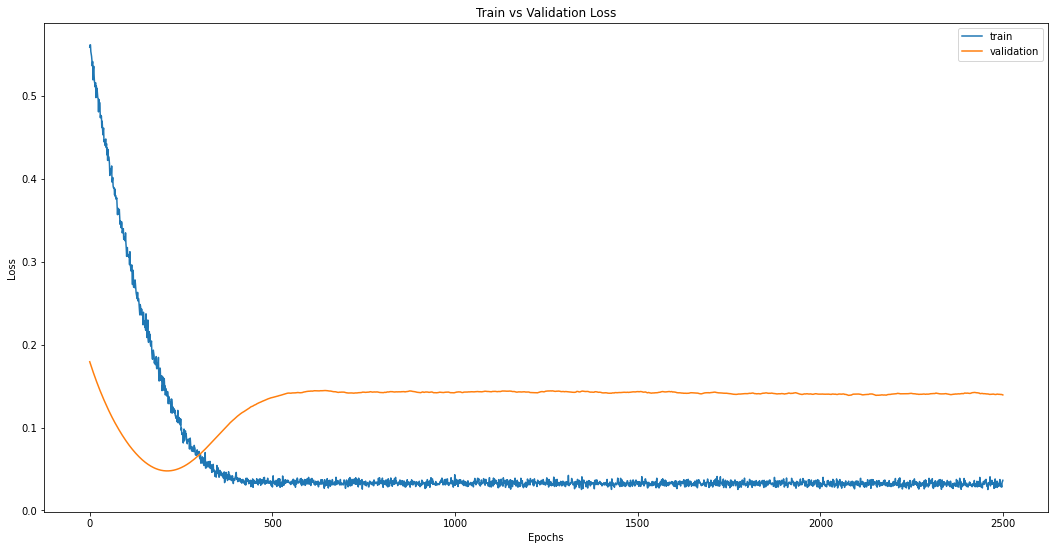

In [14]:
# plot the validation and training loss
plt.figure(figsize=(18,9))
plt.plot(train_loss)
plt.plot(val_loss)
plt.title("Train vs Validation Loss")
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

In [15]:
# X_test[0];
y_pred = np.zeros((X_test.shape[0],n_months))
X_test_model = np.zeros((X_test[0].shape[0],X_test[0].shape[1]))
for i in range(X_test[0].shape[0]):
    for j in range(X_test[0].shape[1]):
        X_test_model[i][j] = X_test[0][i][j]
        
print(X_test[0].shape)
pred = []
# print(X_test_model)
# print(X_test[0])


(10, 1)


In [16]:
for i in range(X_test.shape[0]):
    # print("before X_test_model")
    # print(X_test_model)
    X_test_model = X_test_model.reshape(1,window,n_features)
    # print(X_test_model.shape)
    pred = model.predict(X_test_model,batch_size=batch_size)
    X_test_model.reshape(window,n_features)
    # print(pred)
    # print(pred.shape)
#     print(pred.reshape(n_features,n_months))
    y_pred[i]=np.array(pred.reshape(n_features,n_months))
    # print("\ny_pred")
    # print(y_pred)
#     print("\nX_test_model[0]")
#     print(X_test_model[0][1])
    
    X_test_model[0,:-1] = X_test_model[0,1:]
    X_test_model[0,-1] = pred[0,0]
#     print("\nPred")
#     print(pred)
#     print(pred[0])
#     print("\n after X_test_model")
    # print(X_test_model)



1/1 [==============================] - 0s 38ms/step


In [17]:
# print(y_pred)
# print(y_test)

In [18]:
def inverse_transform(X_scaled,min_data,max_data,min_range=-1,max_range=1):
    X_std = (X_scaled - (min_range))/(max_range-min_range)
    X = X_std * (max_data - min_data) + min_data
    return X

In [19]:
X_test = X_test.reshape(X_test.shape[0],window)

In [20]:

inv_pred = np.concatenate((y_pred, X_test), axis=1)
inv_pred = inverse_transform(inv_pred,min_data,max_data)
inv_pred = inv_pred[:,0:n_months]

inv_test=np.concatenate((y_test,X_test),axis=1)
inv_test = inverse_transform(inv_test,min_data,max_data)
inv_test = inv_test[:,0:n_months]

rmse = mean_squared_error(inv_pred, inv_test) ** (0.5)
print('Test RMSE: %.3f' % rmse)

Test RMSE: 222.936


In [21]:
# print(inv_pred)
# print(inv_test)

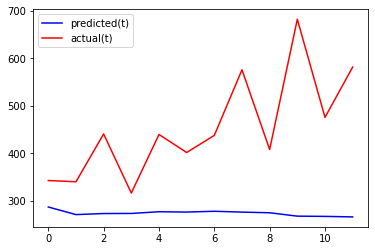

In [22]:
plt.plot(inv_pred[:,0],'b',label="predicted(t)")
plt.plot(inv_test[:,0],'r',label="actual(t)")
plt.legend()
plt.show()

In [23]:
# error calculation for train set
y_pred_tr = np.zeros((X_train.shape[0],n_months))
X_train_model = np.zeros((X_train[0].shape[0],X_train[0].shape[1]))
for i in range(X_train[0].shape[0]):
    for j in range(X_train[0].shape[1]):
        X_train_model[i][j] = X_train[0][i][j]

pred_train = []
# print(X_train_model)
# print(X_train[0])

In [24]:
for i in range(X_train.shape[0]):
#     print("before X_test_model")
#     print(X_train_model)
    X_train_model = X_train_model.reshape(1,window,n_features)

    pred_train = model.predict(X_train_model,batch_size=1)
    X_train_model.reshape(window,n_features)

    y_pred_tr[i]=np.array(pred_train.reshape(n_features,n_months))
#     print("\ny_pred")
#     print(y_pred_tr)

    
    X_train_model[0,:-1] = X_train_model[0,1:]
    X_train_model[0,-1] = pred_train[0,0]
        



1/1 [==============================] - 0s 37ms/step


In [25]:
print(y_pred_tr)
print(y_train)

[[-0.61315972 -0.62824744]
 [-0.67050213 -0.6748445 ]
 [-0.66454506 -0.66662115]
 [-0.65782869 -0.6592589 ]
 [-0.64271379 -0.64519823]
 [-0.63422728 -0.6369679 ]
 [-0.62456423 -0.62767029]
 [-0.62287307 -0.62508047]
 [-0.62060356 -0.62179041]
 [-0.61384916 -0.61485165]
 [-0.59720051 -0.60004288]
 [-0.59400195 -0.59693551]
 [-0.58953887 -0.5924316 ]]
[[-0.22800782 -0.76328417]
 [-0.76328417 -0.73342811]
 [-0.73342811 -0.89266039]
 [-0.89266039 -0.6772703 ]
 [-0.6772703  -0.45263906]
 [-0.45263906 -0.74373556]
 [-0.74373556 -0.40394526]
 [-0.40394526 -0.62075706]
 [-0.62075706 -0.34494402]
 [-0.34494402 -0.39363782]
 [-0.39363782  0.07446241]
 [ 0.07446241 -0.48391683]
 [-0.48391683 -0.20739293]]


In [26]:
X_train = X_train.reshape(X_train.shape[0],window)

In [27]:
inv_pred_tr = np.concatenate((y_pred_tr, X_train), axis=1)
inv_pred_tr = inverse_transform(inv_pred_tr,min_data,max_data)
inv_pred_tr = inv_pred_tr[:,0:n_months]

inv_test_tr=np.concatenate((y_train,X_train),axis=1)
inv_test_tr = inverse_transform(inv_test_tr,min_data,max_data)
inv_test_tr = inv_test_tr[:,0:n_months]

rmse = mean_squared_error(inv_pred_tr, inv_test_tr) ** (0.5)
print('Test RMSE: %.3f' % rmse)

Test RMSE: 73.989


In [28]:
print(inv_pred_tr)
print(inv_test_tr)

[[228.13751387 223.8925828 ]
 [212.00422679 210.78249897]
 [213.68024759 213.09613985]
 [215.56989846 215.1675079 ]
 [219.82247654 219.12347912]
 [222.21015594 221.43908206]
 [224.92885377 224.05496445]
 [225.40466236 224.78361081]
 [226.043188   225.7092684 ]
 [227.94353797 227.66148727]
 [232.6276357  231.82793583]
 [233.5275517  232.70219408]
 [234.78323829 233.96936797]]
[[336.5 185.9]
 [185.9 194.3]
 [194.3 149.5]
 [149.5 210.1]
 [210.1 273.3]
 [273.3 191.4]
 [191.4 287. ]
 [287.  226. ]
 [226.  303.6]
 [303.6 289.9]
 [289.9 421.6]
 [421.6 264.5]
 [264.5 342.3]]


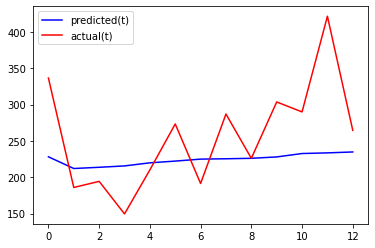

In [29]:
plt.plot(inv_pred_tr[:,0],'b',label="predicted(t)")
plt.plot(inv_test_tr[:,0],'r',label="actual(t)")
plt.legend()
plt.show()